In [55]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [ ]:
# Import data into dataframes
users_df = pd.read_csv('takehome_users.csv', encoding='latin1')
engagement_df = pd.read_csv('takehome_user_engagement.csv', encoding='latin1')

In [4]:
# Head and shape
print(users_df.head())
print(users_df.shape)

print(engagement_df.head())
print(engagement_df.shape)

   object_id        creation_time               name  \
0          1  2014-04-22 03:53:30     Clausen August   
1          2  2013-11-15 03:45:04      Poole Matthew   
2          3  2013-03-19 23:14:52  Bottrill Mitchell   
3          4  2013-05-21 08:09:28    Clausen Nicklas   
4          5  2013-01-17 10:14:20          Raw Grace   

                        email creation_source  last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
2  MitchellBottrill@gustr.com      ORG_INVITE                1.363735e+09   
3   NicklasSClausen@yahoo.com    GUEST_INVITE                1.369210e+09   
4          GraceRaw@yahoo.com    GUEST_INVITE                1.358850e+09   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                         1                           0      11   
1                         0                           0       1   

In [5]:
# dtypes of dataframes
print(users_df.dtypes)
print(engagement_df.dtypes)

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
dtype: object
time_stamp    object
user_id        int64
visited        int64
dtype: object


In [ ]:
# Convert creation_time from string to datetime
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'])
# Convert last_session_creation_time from float to datetime
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'], unit='s')

# Convert time_stamp in engagement_df from string to datetime
engagement_df['time_stamp'] = pd.to_datetime(engagement_df['time_stamp'])

In [7]:
# dtypes of dataframes
print(users_df.dtypes)
print(engagement_df.dtypes)

object_id                              int64
creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                       object
last_session_creation_time    datetime64[ns]
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
dtype: object
time_stamp    datetime64[ns]
user_id                int64
visited                int64
dtype: object


In [8]:
# Check for null values
print("Missing values in users_df:")
print(users_df.isnull().sum())

print("\nMissing values in engagement_df:")
print(engagement_df.isnull().sum())

Missing values in users_df:
object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

Missing values in engagement_df:
time_stamp    0
user_id       0
visited       0
dtype: int64


In [10]:
# Select rows where last_session_creation_time is missing
missing_last_session = users_df[users_df['last_session_creation_time'].isna()]

# Summary of missing last session users
print(f"Number of users with missing last_session_creation_time: {len(missing_last_session)}")

# Check creation_source distribution for missing last_session users
print(missing_last_session['creation_source'].value_counts())

# Check if these users opted into mailing list or marketing drip
print(missing_last_session[['opted_in_to_mailing_list', 'enabled_for_marketing_drip']].mean())

# Look at invited_by_user_id stats for these users
print(missing_last_session['invited_by_user_id'].describe())

# Optionally view a few sample rows
print(missing_last_session.head())


Number of users with missing last_session_creation_time: 3177
creation_source
PERSONAL_PROJECTS    1347
ORG_INVITE           1066
GUEST_INVITE          575
SIGNUP                189
Name: count, dtype: int64
opted_in_to_mailing_list      0.241737
enabled_for_marketing_drip    0.141958
dtype: float64
count     1641.000000
mean      5911.913467
std       3353.670938
min          7.000000
25%       2998.000000
50%       5978.000000
75%       8664.000000
max      11999.000000
Name: invited_by_user_id, dtype: float64
    object_id       creation_time               name  \
7           8 2013-07-31 05:34:02  Hamilton Danielle   
8           9 2013-11-05 04:04:24         Amsel Paul   
11         12 2014-04-17 23:48:38    Mathiesen Lærke   
14         15 2013-07-16 21:33:54        Theiss Ralf   
15         16 2013-02-11 10:09:50         Engel René   

                         email    creation_source last_session_creation_time  \
7   DanielleHamilton@yahoo.com  PERSONAL_PROJECTS                

In [ ]:
# Users missing login seem to be guest invites or org invites that never actually logged in, thus we have no use for them in this analysis
users_df = users_df.dropna(subset=['last_session_creation_time']).reset_index(drop=True)

In [23]:
# Confirm no user id of 0
print("Any user_id == 0?", (users_df['object_id'] == 0).any())
print("Any invited_by_user_id == 0?", (users_df['invited_by_user_id'] == 0).any())

Any user_id == 0? False
Any invited_by_user_id == 0? False


In [24]:
# Fillna with 0 as a placeholder for self signups
users_df['invited_by_user_id'].fillna(0, inplace=True)

In [25]:
# Check for null values
print("Missing values in users_df:")
print(users_df.isnull().sum())

Missing values in users_df:
object_id                     0
creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
dtype: int64


In [27]:
# create target adoption variable
# Get only rows where a user visited
visited_df = engagement_df[engagement_df['visited'] == 1].copy()

In [28]:
# convert to date time and drop duplicates of same users logging in multiple times per day
visited_df['time_stamp'] = pd.to_datetime(visited_df['time_stamp'])
visited_df = visited_df.drop_duplicates(subset=['user_id', 'time_stamp'])

In [29]:
# Group by user and sort
visited_df = visited_df.sort_values(['user_id', 'time_stamp'])

In [31]:
# For each user use sliding window to check last 3 logins within 7 days
adopted_users = set()
grouped = visited_df.groupby('user_id')['time_stamp']

for user_id, dates, in grouped:
    dates = dates.sort_values().reset_index(drop=True)
    for i in range(len(dates) -2):
        if (dates[i+2]-dates[i]).days<=7:
            adopted_users.add(user_id)
            break

In [32]:
# create bnary target dataframe
adopted_df = pd.DataFrame({'user_id': list(adopted_users), 'adopted': 1})

In [34]:
# add new column to users_df for adopted or not
users_df['adopted_user'] = users_df['object_id'].isin(adopted_users).astype(int)

In [37]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0


In [38]:
# Check rate of adoption
adoption_rate = users_df['adopted_user'].mean()
print(f"Adoption rate: {adoption_rate:.2%}")

Adoption rate: 18.77%


creation_source
SIGNUP                0.159115
SIGNUP_GOOGLE_AUTH    0.172563
ORG_INVITE            0.180050
PERSONAL_PROJECTS     0.225131
GUEST_INVITE          0.232368
Name: adopted_user, dtype: float64


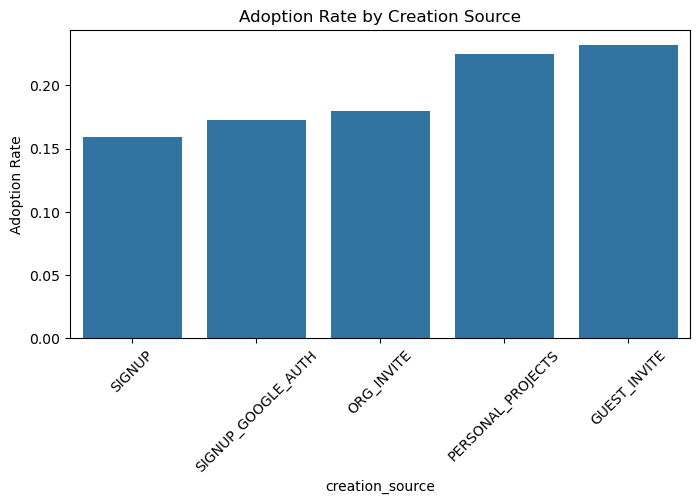

In [42]:
# Adoption rate by creation_source
creation_source_adopt = users_df.groupby('creation_source')['adopted_user'].mean().sort_values()
print(creation_source_adopt)

plt.figure(figsize=(8,4))
sns.barplot(x=creation_source_adopt.index, y=creation_source_adopt.values)
plt.title('Adoption Rate by Creation Source')
plt.ylabel('Adoption Rate')
plt.xticks(rotation=45)
plt.show()

opted_in_to_mailing_list
0    0.185994
1    0.192722
Name: adopted_user, dtype: float64


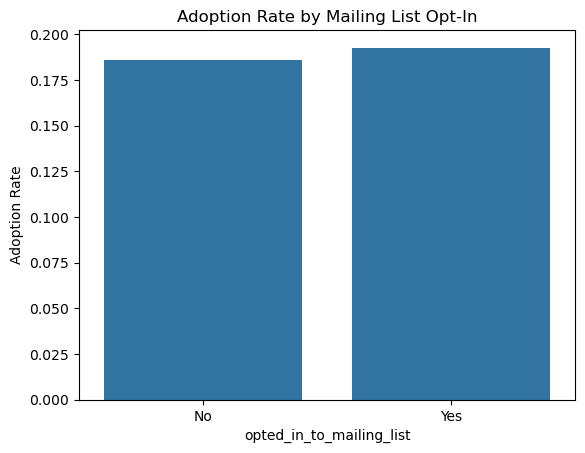

In [43]:
# Adoption rate by mailing list opt-in
mailing_adopt = users_df.groupby('opted_in_to_mailing_list')['adopted_user'].mean()
print(mailing_adopt)

sns.barplot(x=mailing_adopt.index, y=mailing_adopt.values)
plt.title('Adoption Rate by Mailing List Opt-In')
plt.ylabel('Adoption Rate')
plt.xticks([0,1], ['No', 'Yes'])
plt.show()

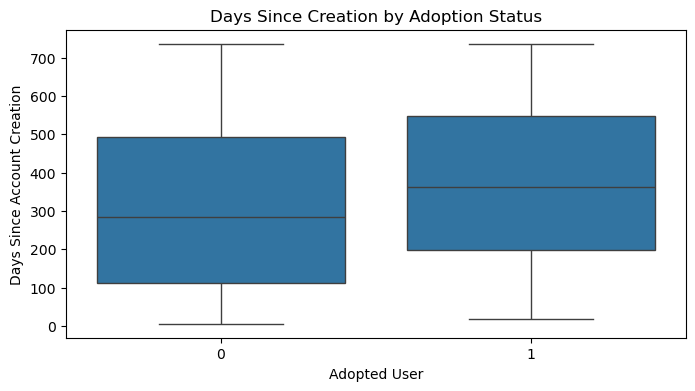

In [48]:
# Numerical feature: days since creation
max_date = users_df['last_session_creation_time'].max()
users_df['days_since_creation'] = (max_date - users_df['creation_time']).dt.days

plt.figure(figsize=(8,4))
sns.boxplot(x='adopted_user', y='days_since_creation', data=users_df)
plt.title('Days Since Creation by Adoption Status')
plt.xlabel('Adopted User')
plt.ylabel('Days Since Account Creation')
plt.show()

Preprocessing

In [ ]:
# Dtype check
users_df.dtypes

object_id                              int64
creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                       object
last_session_creation_time    datetime64[ns]
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
adopted_user                           int64
days_since_creation                    int64
days_since_last_session                int64
dtype: object

In [50]:
# Drop columns
df = users_df.drop(columns=['name', 'object_id', 'email', 'creation_time', 'last_session_creation_time'])

In [51]:
# One-hot encode creation_source
df = pd.get_dummies(df, columns=['creation_source'], drop_first=True)

In [52]:
df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,days_since_creation,days_since_last_session,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,11,10803.0,0,45,4110,False,False,False,False
1,0,0,1,316.0,1,203,4132,True,False,False,False
2,0,0,94,1525.0,0,443,4508,True,False,False,False
3,0,0,1,5151.0,0,381,4445,False,False,False,False
4,0,0,193,5240.0,0,505,4565,False,False,False,False


In [ ]:
# Split into 80/20 train test split, stratify due to imbalanced data
X = df.drop('adopted_user', axis=1)
y = df['adopted_user']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [59]:
# Initialize random forest and logistic regression models
models = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(random_state=42))
    ]),
    "Random Forest": Pipeline([
        ('rf', RandomForestClassifier(random_state=42))
    ])
}

In [60]:
# Loop to produce both models and evaluation metrics
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"\n{name} Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"{name} ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
    print("\n" + "-"*40 + "\n")



Logistic Regression Confusion Matrix:
[[1421   13]
 [  48  283]]

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1434
           1       0.96      0.85      0.90       331

    accuracy                           0.97      1765
   macro avg       0.96      0.92      0.94      1765
weighted avg       0.97      0.97      0.96      1765

Logistic Regression ROC AUC Score: 0.9843

----------------------------------------


Random Forest Confusion Matrix:
[[1420   14]
 [  67  264]]

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1434
           1       0.95      0.80      0.87       331

    accuracy                           0.95      1765
   macro avg       0.95      0.89      0.92      1765
weighted avg       0.95      0.95      0.95      1765

Random Forest ROC AUC Score: 0.9718

----------------

We used user and engagement data to predict whether users adopted the product, defined as logging in three times in one week. After cleaning and basic feature engineering, we tested logistic regression and random forest models without tuning. Logistic regression performed best with about 97% accuracy and good recall. Adoption was more common for users invited through guests or personal projects and those with older accounts. These initial models show promise but need further tuning and more data to improve. Ultimate can use these insights to focus retention efforts on key user groups.